In [1]:
from causalimpact import CausalImpact

import numpy as np
import pandas as pd
import datetime
from datetime import datetime

from statsmodels.tsa.arima_process import ArmaProcess

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.plotting import register_matplotlib_converters

In [3]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [4]:
data = pd.read_csv("subs_dashboard_total.csv", parse_dates=['Date'],skiprows = 1,  usecols=[0,1, 2, 3,4], names=['Date','Acquired Users', 'Trials', 'Direct Subs', 'Intro Subs'])

In [5]:
data

,Date,Acquired Users,Trials,Direct Subs,Intro Subs
0,2022-05-01,732,612,68,52
1,2022-05-02,954,780,110,64
2,2022-05-03,993,821,119,53
3,2022-05-04,"1,096",870,131,95
4,2022-05-05,"1,218",997,141,80
...,...,...,...,...,...
195,2022-11-12,896,740,99,57
196,2022-11-13,568,454,74,40
197,2022-11-14,926,761,107,58
198,2022-11-15,"1,151",985,118,48


In [6]:
data.dtypes

Date              datetime64[ns]
Acquired Users            object
Trials                    object
Direct Subs                int64
Intro Subs                 int64
dtype: object

In [7]:
data['Acquired Users']  = data['Acquired Users'] .str.replace(',', '').astype(str).astype(int)
data['Trials']  = data['Trials'] .str.replace(',', '').astype(str).astype(int)

In [8]:
data.dtypes

Date              datetime64[ns]
Acquired Users             int32
Trials                     int32
Direct Subs                int64
Intro Subs                 int64
dtype: object

In [9]:
data.set_index('Date', inplace=True)

In [10]:
subs = data[['Acquired Users']]

In [11]:
subs.shape

(200, 1)

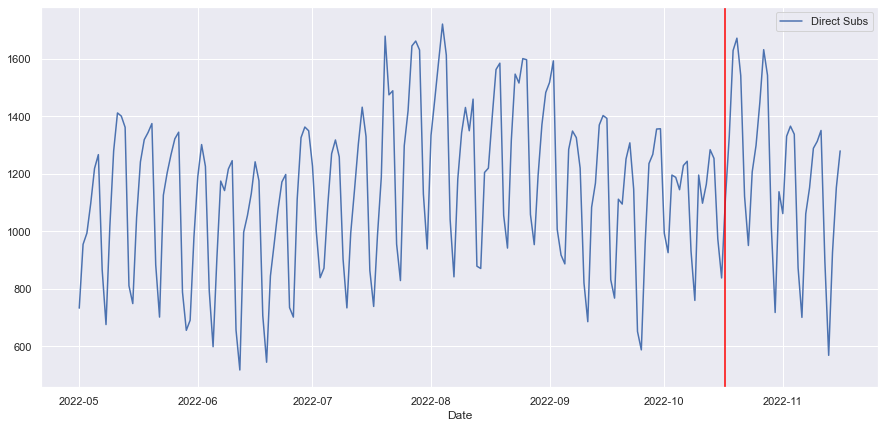

In [12]:
sns.set(rc={'figure.figsize':(15,7)})
sns.lineplot(x=subs.index, y=subs['Acquired Users'].values)
plt.axvline(subs[subs.index == '2022-10-17'].index, color='red')
plt.legend(labels = ['Direct Subs'])

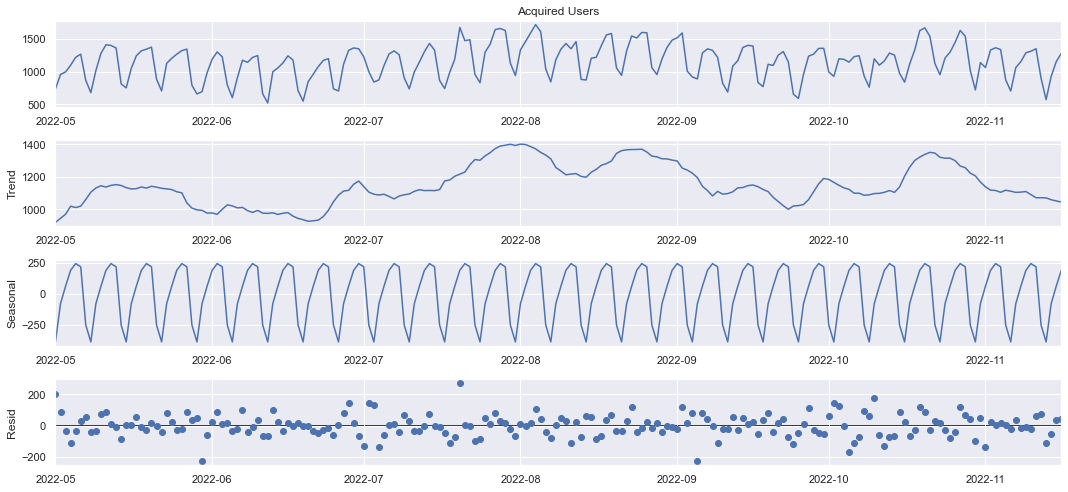

In [13]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(subs['Acquired Users'], model = 'additive', extrapolate_trend = 'freq')
result.plot()
plt.show()

Weekly seasonality

In [14]:
print('Acquired for the post period: ',subs.loc[subs.index >= '2022-10-17'].sum())

Acquired for the post period:  Acquired Users    36995
dtype: int64


In [15]:
print('Acquired for the pre period: ', subs.loc[subs.index < '2022-10-17'].sum())

Acquired for the pre period:  Acquired Users    192388
dtype: int64


In [16]:
# Set pre-period
pre_period = [str('2022-05-01'), str('2022-10-16')]
# Set post-period
post_period = [str('2022-10-17'), str('2022-11-16')]

In [17]:
print('Pre-period is from ', pre_period[0], ' to ', pre_period[1])
print('Post-period is from ', post_period[0], ' to ', post_period[1])

Pre-period is from  2022-05-01  to  2022-10-16
Post-period is from  2022-10-17  to  2022-11-16


Causal impact model

C:\Users\mgrgic\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\mgrgic\Anaconda3\lib\site-packages\statsmodels\base\optimizer.py:17: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score. The list of unsupported keyword arguments passed include: standardize, nseasons. After release 0.14, this will raise.
  warnings.warn(


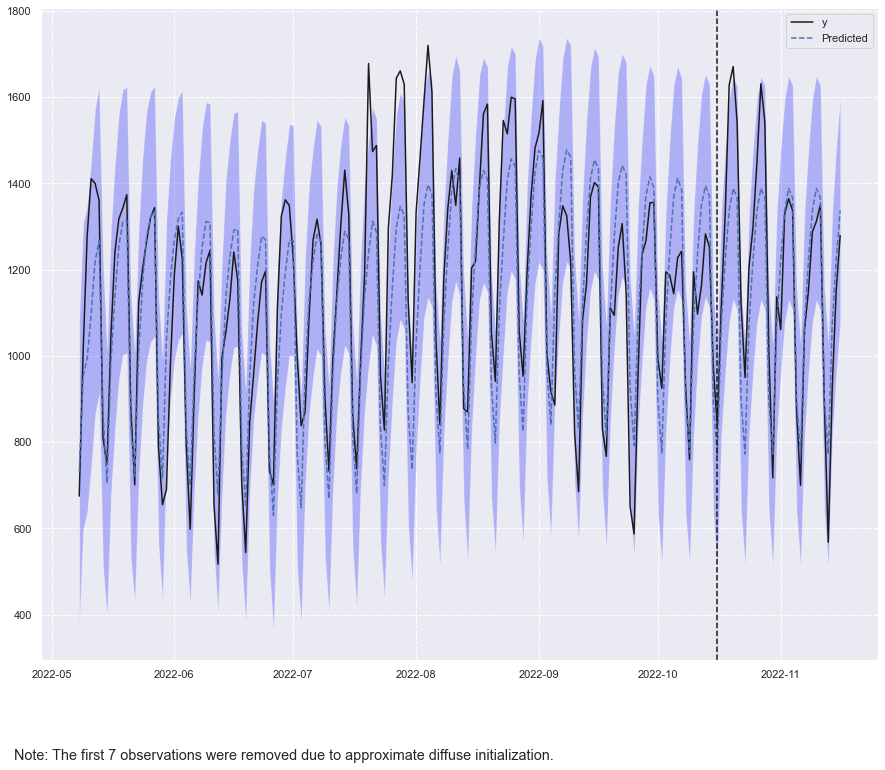

In [18]:
# Causal impact model, prior_level_sd default of 0.01
impact = CausalImpact(data=subs, pre_period=pre_period, post_period=post_period,
                      #prior_level_sd = None,
                     nseasons=[{'period': 7}]
                     )
impact.plot(panels=['original'])

In [19]:
print(impact.summary('report'))

Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 1193.39. In the absence of an
intervention, we would have expected an average response of 1156.69.
The 95% interval of this counterfactual prediction is [1091.09, 1219.36].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is 36.69 with a 95% interval of
[-25.97, 102.29]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 36995.0.
Had the intervention not taken place, we would have expected
a sum of 35857.47. The 95% interval of this prediction is [33823.91, 37800.19].


The above results are given in terms of absolute numbers. In relative
terms, the response variable showed

**increase of +3.17%** \
observed: 36995 \
predicted: 35857.47 \
difference: 1138